In [1]:
import tsfel
import glob
import joblib
import pickle
import pandas as pd
import numpy as np
import seaborn as sns

import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import confusion_matrix, accuracy_score


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings("ignore")

In [2]:
#!pip install sklearn.impute
#!pip install matplotlib
#!pip install -U Pillow
#!pip install seaborn
#!pip uninstall scipy
#!pip install scipy==1.8.1
#pip list
#!pip install cPickle

In [3]:
def parsing(folder_name, fs=50):
    
    """Принимает на вход название папки  из директории в которой находится датасет.
    Файлы должны быть записаны как Accel_sub_ и Gyr_sub_ соотвественно.
    feature_class = temporal or statistical or spectral.
    Возвращает df с модулями акселерометра и гироскопа"""


    # Загрузка датасета
    files = glob.glob('C:\\Users\\Virtus\\Desktop\\Muscule_fatigue\\DataSet\\'+folder_name+'\\Accel_sub*.csv')
    df1 = pd.DataFrame()
    
    for file in files:
        data = pd.read_csv(file)
        data = data.iloc[:-fs*5]
        data = data.iloc[fs*5:]
        df1 = df1.append(data)
    
    
    files = glob.glob('C:\\Users\\Virtus\\Desktop\\Muscule_fatigue\\DataSet\\'+folder_name+'\\Gyr_sub*.csv')
    df2 = pd.DataFrame()
    
    for file in files:
        data = pd.read_csv(file)
        data = data.iloc[:-fs*5]
        data = data.iloc[fs*5:]
        df2 = df2.append(data)
    
    
    # Находим модуль
    df1 = pd.DataFrame((df1['X (m/s^2)'] ** 2 + df1['Y (m/s^2)'] ** 2 + df1['Z (m/s^2)'] ** 2) ** 0.5)
    df2 = pd.DataFrame((df2['X (rad/s)'] ** 2 + df2['Y (rad/s)'] ** 2 + df2['Z (rad/s)'] ** 2) ** 0.5)

    
    df1.columns = ['acc']
    df2.columns = ['gyr']

    #sns.boxplot(data=[df1, df2],orient='h')
    
    # Удаление выбросов по квантилям 
    Q1 = df1.quantile(q=.25)
    Q3 = df1.quantile(q=.75)
    IQR = df1.apply(stats.iqr)
    df1 = df1[~((df1 < (Q1 - 1.5 * IQR)) | (df1 > (Q3 + 1.5 * IQR))).any(axis=1)]

    Q1 = df2.quantile(q=.25)
    Q3 = df2.quantile(q=.75)
    IQR = df2.apply(stats.iqr)
    df2 = df2[~((df2 < (Q1 - 1.5 * IQR)) | (df2 > (Q3 + 1.5 * IQR))).any(axis=1)]

    #Объединяем в один датафрейм
    df = pd.merge(df1, df2, left_index=True, right_index=True)
    #sns.boxplot(data=df,orient='h')
    
    return df

In [4]:
def features(df, feature_class, fs=50, window_size=250):

    '''Принимает на вход df, feature_class - параметр, определяющий какой тип 
    признаков будет извлечен, feature_class = temporal or statistical or spectral.
    Возвращает df с признаками.'''
    
    # Выбор признаков которые будут извлечены 
    cfg = tsfel.get_features_by_domain(feature_class)
    
    # Извлечение признаков
    X_train = tsfel.time_series_features_extractor(cfg, df, fs=fs, window_size=window_size,
                                                    header_names=['acc', 'gyr'])
    
    # Удаление признаков с высокой корреляцией
    corr_features = tsfel.correlated_features(X_train, threshold=0.6)
    X_train.drop(corr_features, axis=1, inplace=True)
    
    # Удаление признаков с низкой дисперсией, threshold - уровень 'схожести' столбцов
    var_thr = VarianceThreshold(threshold=0.3)
    var_thr.fit_transform(X_train)
    concol = [column for column in X_train.columns
            if column not in X_train.columns[var_thr.get_support()]]
    X_train = X_train.drop(concol, axis=1)
    
    # Нормализация признаков
    nX_train = pd.DataFrame(preprocessing.normalize(X_train))
    nX_train.columns = X_train.columns
    
    # Запись таблицы с признаками
    nX_train = pd.DataFrame(nX_train)
    
    return nX_train

In [5]:
# Создаем df с датасета
df1 = parsing('Not_Tired')
df2 = parsing('Average_Fatigue')
df3 = parsing('High_Fatigue')

In [6]:
# Вычисляем статистические признаки
NotFatig_stat  = features(df=df1, feature_class='statistical')
AverFatig_stat = features(df=df2, feature_class='statistical')
HighFatig_stat = features(df=df3, feature_class='statistical')

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


In [7]:
# Вычисляем временные признаки
NotFatig_temp  = features(df=df1, feature_class='temporal')
AverFatig_temp = features(df=df2, feature_class='temporal')
HighFatig_temp = features(df=df3, feature_class='temporal')

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


In [8]:
# Вычисляем спектральные признаки
NotFatig_spec  = features(df=df1, feature_class='spectral')
AverFatig_spec = features(df=df2, feature_class='spectral')
HighFatig_spec = features(df=df3, feature_class='spectral')

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


In [9]:
# Объединяем df с признакми
NotFatig_Data  = pd.concat([NotFatig_stat, NotFatig_temp, NotFatig_spec], axis=1, join='inner')
AverFatig_Data = pd.concat([AverFatig_stat, AverFatig_temp, AverFatig_spec], axis=1, join='inner')
HighFatig_Data = pd.concat([HighFatig_stat, HighFatig_temp, HighFatig_spec], axis=1, join='inner')

In [10]:
NotFatig_Data2 = NotFatig_Data[NotFatig_Data != 0]

#В каких колонках больше 40% нулей
missing_features = NotFatig_Data2.columns[NotFatig_Data2.isnull().mean() > 0.40]
NotFatig_Data = NotFatig_Data2.drop(missing_features, axis=1)#, inplace=True)
missing_features

Index(['acc_Histogram_5', 'acc_Histogram_6', 'acc_Histogram_7',
       'acc_Histogram_8', 'acc_Histogram_9', 'gyr_Histogram_5',
       'gyr_Histogram_6'],
      dtype='object')

In [11]:
AverFatig_Data2 = AverFatig_Data[AverFatig_Data != 0]

#В каких колонках больше 40% нулей
missing_features = AverFatig_Data2.columns[AverFatig_Data2.isnull().mean() > 0.40]
AverFatig_Data = AverFatig_Data2.drop(missing_features, axis=1)#, inplace=True)
missing_features

Index(['acc_Histogram_6', 'acc_Histogram_7', 'acc_Histogram_8',
       'acc_Histogram_9', 'gyr_Histogram_5', 'gyr_Histogram_6'],
      dtype='object')

In [12]:
HighFatig_Data2 = HighFatig_Data[HighFatig_Data != 0]

#В каких колонках больше 40% нулей
missing_features = HighFatig_Data2.columns[HighFatig_Data2.isnull().mean() > 0.40]
HighFatig_Data = HighFatig_Data2.drop(missing_features, axis=1)#, inplace=True)
missing_features

Index(['acc_Histogram_5', 'acc_Histogram_9', 'gyr_Histogram_6'], dtype='object')

In [13]:
#Nan --->0
NotFatig_Data = NotFatig_Data[NotFatig_Data != 0]
NotFatig_Data = NotFatig_Data.apply(lambda row: row.fillna(row.mean()), axis=1)

In [14]:
AverFatig_Data = AverFatig_Data[AverFatig_Data != 0]
AverFatig_Data = AverFatig_Data.apply(lambda row: row.fillna(row.mean()), axis=1)

In [15]:
HighFatig_Data = HighFatig_Data[HighFatig_Data != 0]
HighFatig_Data = HighFatig_Data.apply(lambda row: row.fillna(row.mean()), axis=1)

In [16]:
NotFatig_Data

,acc_ECDF Percentile_0,acc_ECDF Percentile_1,acc_Kurtosis,acc_Max,acc_Min,gyr_Histogram_7,gyr_Histogram_8,gyr_Histogram_9,gyr_Kurtosis,acc_Absolute energy,...,gyr_MFCC_4,gyr_MFCC_5,gyr_MFCC_6,gyr_MFCC_7,gyr_MFCC_8,gyr_MFCC_9,gyr_Maximum frequency,gyr_Median frequency,gyr_Power bandwidth,gyr_Spectral positive turning points
0,0.015066,0.045585,0.012896,0.080286,0.007778,0.156857,0.888854,0.287570,-0.005336,0.946521,...,0.000605,0.001641,0.000788,-0.000956,0.001788,0.001592,0.000262,0.000106,0.000241,0.000117
1,0.028742,0.108266,-0.007240,0.164571,0.013245,0.153182,0.891241,0.320290,-0.005156,0.997115,...,0.000221,0.000853,0.000512,-0.000352,0.000284,0.000435,0.000121,0.000049,0.000111,0.000103
2,0.013705,0.061242,0.013395,0.134902,0.006642,0.165323,0.606183,0.316868,-0.012525,0.992242,...,0.000285,0.001135,0.001177,0.000705,0.000966,0.000931,0.000173,0.000069,0.000138,0.000076
3,0.031152,0.091593,-0.021013,0.116779,0.017452,0.344263,0.791805,0.464755,-0.016394,0.990608,...,0.000419,0.000580,0.000676,0.000661,0.000634,0.000867,0.000197,0.000073,0.000175,0.000308
4,0.020395,0.103716,-0.011553,0.158194,0.002734,0.440871,0.614547,0.467590,-0.014669,0.997521,...,0.000694,-0.000010,0.000575,-0.000114,-0.000152,0.000184,0.000124,0.000038,0.000100,0.000054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4601,0.052135,0.144794,-0.006606,0.240878,0.020646,0.271194,0.225995,0.881381,0.005379,0.994505,...,-0.000545,-0.000600,-0.000175,0.002268,-0.000385,-0.000479,0.000173,0.000007,0.000175,0.000262
4602,0.024729,0.095180,-0.011631,0.142798,0.009566,0.585920,0.614501,0.400140,0.021457,0.997274,...,-0.000564,-0.000676,-0.000027,0.002525,-0.000309,-0.000812,0.000181,0.000085,0.000169,0.000282
4603,0.028358,0.090154,-0.019653,0.116305,0.018431,0.505623,0.794551,0.270870,-0.022388,0.976560,...,-0.001578,0.001058,-0.001697,0.003401,0.001250,-0.003081,0.000259,0.000125,0.000133,0.000326
4604,0.077388,0.183017,-0.000529,0.304763,0.034204,0.294205,0.748884,0.401188,-0.013685,0.996345,...,-0.000398,0.001736,-0.000684,-0.000418,0.003112,-0.001022,0.000144,0.000041,0.000114,0.000291


In [17]:
# Прописываем метки
NotFatig_Data['class']  = 0
AverFatig_Data['class'] = 1
HighFatig_Data['class'] = 2

In [18]:
# Объединяем в один датафрейм
FeatureData = pd.concat([NotFatig_Data, AverFatig_Data, HighFatig_Data], axis=0) #AverFatig_Data

In [19]:
#FeatureData#.dropna(axis=1)
FeatureData.head()

,acc_ECDF Percentile_0,acc_ECDF Percentile_1,acc_Kurtosis,acc_Max,acc_Min,gyr_Histogram_7,gyr_Histogram_8,gyr_Histogram_9,gyr_Kurtosis,acc_Absolute energy,...,acc_FFT mean coefficient_4,acc_FFT mean coefficient_8,acc_Spectral kurtosis,gyr_FFT mean coefficient_77,gyr_MFCC_0,gyr_MFCC_1,gyr_Spectral decrease,acc_FFT mean coefficient_15,gyr_MFCC_2,gyr_MFCC_3
0,0.015066,0.045585,0.012896,0.080286,0.007778,0.156857,0.888854,0.287570,-0.005336,0.946521,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.028742,0.108266,-0.007240,0.164571,0.013245,0.153182,0.891241,0.320290,-0.005156,0.997115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.013705,0.061242,0.013395,0.134902,0.006642,0.165323,0.606183,0.316868,-0.012525,0.992242,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.031152,0.091593,-0.021013,0.116779,0.017452,0.344263,0.791805,0.464755,-0.016394,0.990608,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.020395,0.103716,-0.011553,0.158194,0.002734,0.440871,0.614547,0.467590,-0.014669,0.997521,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
FeatureData = FeatureData.dropna(axis=1)

In [21]:
FeatureData['class'].value_counts()

0    4606
1    2167
2    1922
Name: class, dtype: int64

In [22]:
FeatureData.to_csv('C:\\Users\\Virtus\\Desktop\\Muscule_fatigue\\isMuscle_notebook\\Feature.csv', index=False)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(FeatureData, FeatureData['class'], train_size=0.7, random_state=42)                                                    

In [24]:
print(X_train.var())
print(X_test.var())

acc_ECDF Percentile_0                   1.834265e-03
acc_ECDF Percentile_1                   8.015801e-03
acc_Kurtosis                            7.986935e-04
acc_Max                                 1.631118e-02
acc_Min                                 7.446978e-04
gyr_Histogram_7                         6.593902e-02
gyr_Histogram_8                         7.262039e-02
gyr_Histogram_9                         7.210189e-02
gyr_Kurtosis                            7.027831e-04
acc_Absolute energy                     1.184327e-04
acc_Peak to peak distance               2.215309e-07
gyr_Absolute energy                     2.810362e-03
gyr_Negative turning points             5.867078e-05
gyr_Neighbourhood peaks                 7.559682e-05
acc_FFT mean coefficient_1              6.646737e-10
acc_FFT mean coefficient_10             5.009364e-11
acc_FFT mean coefficient_2              6.085615e-10
acc_FFT mean coefficient_3              4.246018e-10
acc_FFT mean coefficient_6              1.9605

In [25]:
a = pd.DataFrame(X_train.columns)
a = a.transpose()
a.to_excel('C:\\Users\\Virtus\\Desktop\\Muscule_fatigue\\Shapka.xlsx', index = False)

In [26]:
#X_train['class'].value_counts()
#X_test['class'].value_counts()

In [27]:
X_train = X_train.drop(columns=['class'], axis=1)
X_test = X_test.drop(columns=['class'], axis=1)

In [28]:
activity_labels = np.array(pd.read_csv('C:\\Users\\Virtus\\Desktop\\Muscule_fatigue\\isMuscle_notebook\\activity_labels.txt', header=None, delimiter=' '))[:,1]
activity_labels

array(['Не_усталая', 'Средняя_усталость', 'Высокая_усталость'],
      dtype=object)

In [29]:
classifier = RandomForestClassifier(n_jobs=-1, random_state=42)
# Train the classifier
classifier.fit(X_train, y_train.ravel())

# Predict test data
y_test_predict = classifier.predict(X_test)

# Get the classification report
accuracy = accuracy_score(y_test, y_test_predict) * 100
print(classification_report(y_test, y_test_predict, target_names=activity_labels))
print("Accuracy: " + str(accuracy) + '%')

                   precision    recall  f1-score   support

       Не_усталая       0.95      0.97      0.96      1382
Средняя_усталость       0.89      0.84      0.86       662
Высокая_усталость       0.90      0.90      0.90       565

         accuracy                           0.92      2609
        macro avg       0.91      0.90      0.91      2609
     weighted avg       0.92      0.92      0.92      2609

Accuracy: 92.25756995017248%


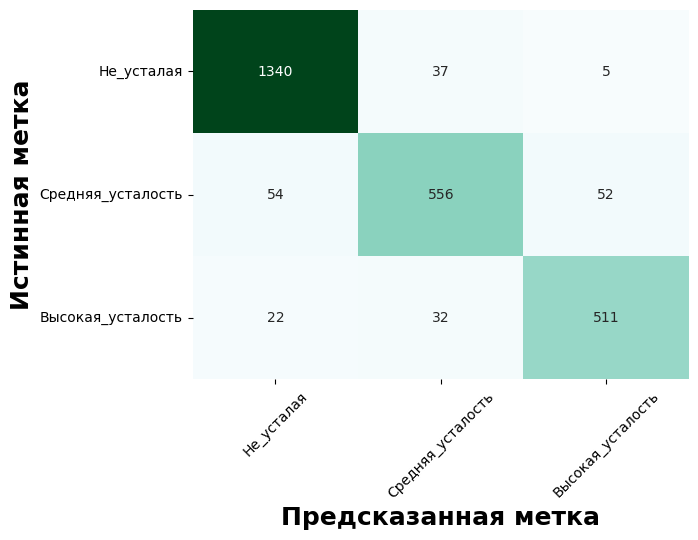

In [30]:
#@title Confusion Matrix
cm = confusion_matrix(y_test, y_test_predict)
df_cm = pd.DataFrame(cm, index=[i for i in activity_labels], columns=[i for i in activity_labels])
plt.figure()
ax= sns.heatmap(df_cm,  cbar=False, cmap="BuGn", annot=True, fmt="d")
plt.setp(ax.get_xticklabels(), rotation=45)

plt.ylabel('Истинная метка', fontweight='bold', fontsize = 18)
plt.xlabel('Предсказанная метка', fontweight='bold', fontsize = 18)
bottom, top = ax.get_ylim()
plt.show()

In [32]:
#Сохранение и загрузка модели
with open('RandomForest.pkl', 'wb') as file:
    pickle.dump(classifier, file)
    
with open('RandomForest.pkl', 'rb') as file:
    classifier_new = pickle.load(file)    

In [33]:
feature_names = X_train.columns

In [34]:
len(feature_names)

40

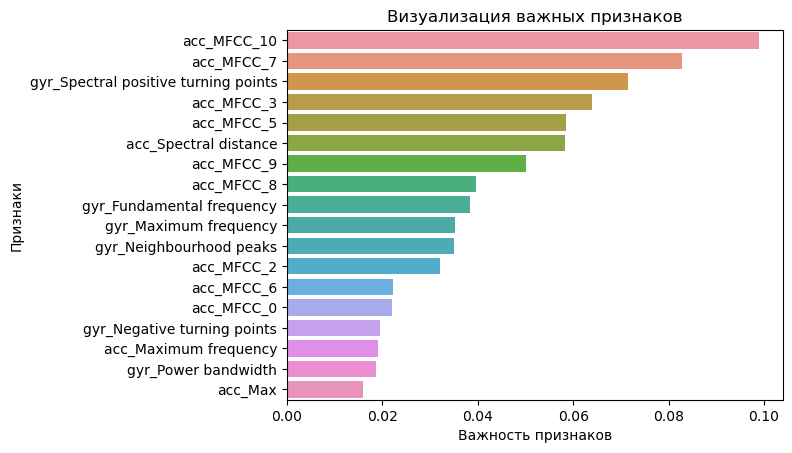

In [38]:
feature_imp = pd.Series(classifier.feature_importances_,index=feature_names).sort_values(ascending=False)
sns.barplot(x=feature_imp[0:18], y=feature_imp.index[0:18])

plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title('Визуализация важных признаков')
plt.show()

In [39]:
feature_imp[0:18]

acc_MFCC_10                             0.099013
acc_MFCC_7                              0.082854
gyr_Spectral positive turning points    0.071499
acc_MFCC_3                              0.063897
acc_MFCC_5                              0.058580
acc_Spectral distance                   0.058360
acc_MFCC_9                              0.050045
acc_MFCC_8                              0.039728
gyr_Fundamental frequency               0.038313
gyr_Maximum frequency                   0.035164
gyr_Neighbourhood peaks                 0.034921
acc_MFCC_2                              0.032129
acc_MFCC_6                              0.022251
acc_MFCC_0                              0.021998
gyr_Negative turning points             0.019516
acc_Maximum frequency                   0.019072
gyr_Power bandwidth                     0.018629
acc_Max                                 0.015886
dtype: float64

In [40]:
# Среднее по кросс-валидации
print(np.mean(cross_val_score(classifier, X_train, y_train, cv=5)))

0.9127501339129708


In [44]:
# Нахождение оптимальных диапазонов через RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(classifier, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 

Text(0, 0.5, 'Ошибка')

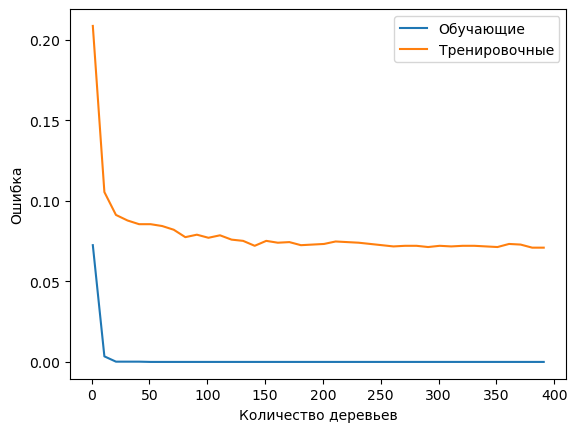

In [64]:
# Проверка на оптимальное количество деревьев в лесу (n_estimators)

x = list()
y = list()

for n in range(1,401,10):  
    classifier = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators = n)
    classifier.fit(X_train, y_train)
    x.append(f1_score(y_train, classifier.predict(X_train), average='micro'))
    y.append(f1_score(y_test, classifier.predict(X_test), average='micro'))
    
x = 1-pd.DataFrame(x)   
y = 1-pd.DataFrame(y) 
#plt.title("plt.title('Training vs. Validation Error')")

n = range(1,401,10)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(n, x, label = 'Обучающие')
ax1.plot(n, y, label = 'Тренировочные')
plt.legend()
plt.xlabel("Количество деревьев")
plt.ylabel("Ошибка")

Text(0, 0.5, 'Ошибка')

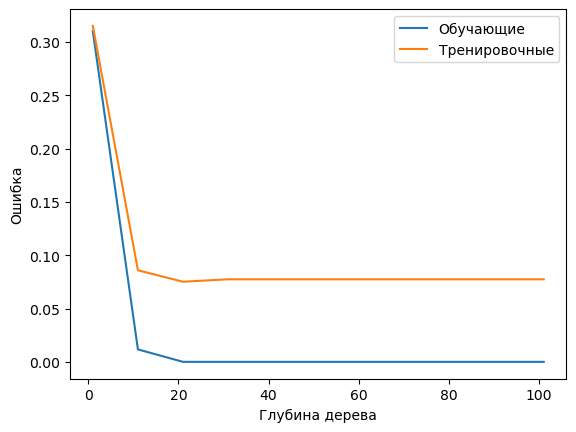

In [65]:
# Проверка на оптимальную глубину дерева (max_depth)

x = list()
y = list()

for n in range(1,102,10):  
    classifier = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth = n)
    classifier.fit(X_train, y_train)
    x.append(f1_score(y_train, classifier.predict(X_train), average='micro'))
    y.append(f1_score(y_test, classifier.predict(X_test), average='micro'))
    
x = 1-pd.DataFrame(x)   
y = 1-pd.DataFrame(y) 
# # #plt.title("")

n = range(1,102,10)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(n, x, label = 'Обучающие')
ax1.plot(n, y, label = 'Тренировочные')
plt.legend()
plt.xlabel("Глубина дерева")
plt.ylabel("Ошибка")

Text(0, 0.5, 'Ошибка')

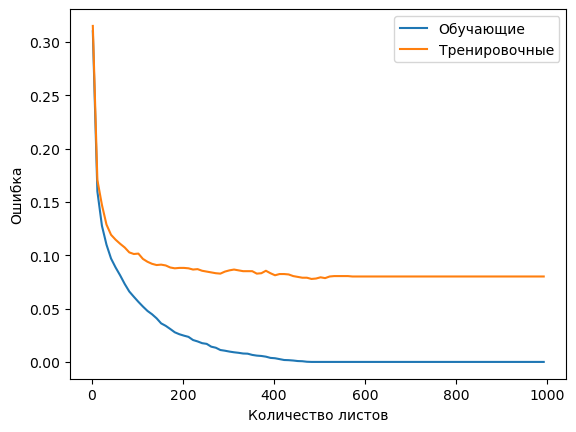

In [66]:
# Проверка на оптимальное количество листов (max_leaf_nodes)

x = list()
y = list()

for n in range(2,1000,10):  
    classifier = RandomForestClassifier(random_state=42, n_jobs=-1, max_leaf_nodes = n)
    classifier.fit(X_train, y_train)
    x.append(f1_score(y_train, classifier.predict(X_train), average='micro'))
    y.append(f1_score(y_test, classifier.predict(X_test), average='micro'))
    
x = 1-pd.DataFrame(x)   
y = 1-pd.DataFrame(y) 
# # #plt.title("")

n = range(2,1000,10)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(n, x, label = 'Обучающие')
ax1.plot(n, y, label = 'Тренировочные')
plt.legend()
plt.xlabel("Количество листов")
plt.ylabel("Ошибка")

Text(0, 0.5, 'Ошибка')

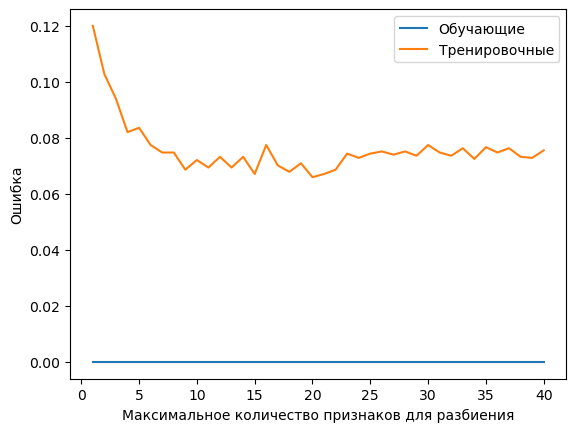

In [67]:
# Проверка на оптимальное количество признаков (max_features)

x = list()
y = list()

for n in range(1,41):  
    classifier = RandomForestClassifier(random_state=42, n_jobs=-1, max_features = n)
    classifier.fit(X_train, y_train)
    x.append(f1_score(y_train, classifier.predict(X_train), average='micro'))
    y.append(f1_score(y_test, classifier.predict(X_test), average='micro'))
    
x = 1-pd.DataFrame(x)   
y = 1-pd.DataFrame(y) 
# # #plt.title("")

n = range(1,41)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(n, x, label = 'Обучающие')
ax1.plot(n, y, label = 'Тренировочные')
plt.legend()
plt.xlabel("Максимальное количество признаков для разбиения")
plt.ylabel("Ошибка")

Text(0, 0.5, 'Ошибка')

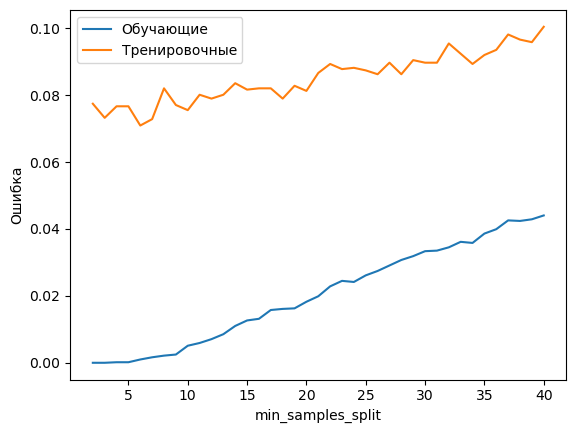

In [68]:
# Проверка на оптимальное разбиение (min_samples_split и min_samples_leaf)

x = list()
y = list()

for n in range(2,41):  
    classifier = RandomForestClassifier(random_state=42, n_jobs=-1, min_samples_split = n)
    classifier.fit(X_train, y_train)
    x.append(f1_score(y_train, classifier.predict(X_train), average='micro'))
    y.append(f1_score(y_test, classifier.predict(X_test), average='micro'))
    
x = 1-pd.DataFrame(x)   
y = 1-pd.DataFrame(y) 
# # #plt.title("")

n = range(2,41)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(n, x, label = 'Обучающие')
ax1.plot(n, y, label = 'Тренировочные')
plt.legend()
plt.xlabel("min_samples_split")
plt.ylabel("Ошибка")

Text(0, 0.5, 'Ошибка')

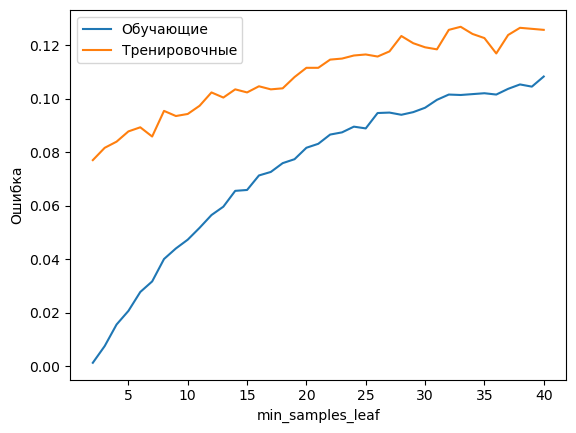

In [69]:
# Проверка на оптимальное разбиение (min_samples_split и min_samples_leaf)

x = list()
y = list()

for n in range(2,41):  
    classifier = RandomForestClassifier(random_state=42, n_jobs=-1, min_samples_leaf = n)
    classifier.fit(X_train, y_train)
    x.append(f1_score(y_train, classifier.predict(X_train), average='micro'))
    y.append(f1_score(y_test, classifier.predict(X_test), average='micro'))
    
x = 1-pd.DataFrame(x)   
y = 1-pd.DataFrame(y) 
# # #plt.title("")

n = range(2,41)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(n, x, label = 'Обучающие')
ax1.plot(n, y, label = 'Тренировочные')
plt.legend()
plt.xlabel("min_samples_leaf")
plt.ylabel("Ошибка")

In [62]:
# Проверка на индекс Джина 

classifier = RandomForestClassifier(random_state=42, n_jobs=-1, min_impurity_decrease = 1e-12)
classifier.fit(X_train, y_train)
print(f1_score(y_train, classifier.predict(X_train), average='micro'), 
      f1_score(y_test, classifier.predict(X_test), average='micro'))


classifier = RandomForestClassifier(random_state=42, n_jobs=-1, min_impurity_decrease = 1e-7)
classifier.fit(X_train, y_train)
print(f1_score(y_train, classifier.predict(X_train), average='micro'), 
      f1_score(y_test, classifier.predict(X_test), average='micro'))

classifier = RandomForestClassifier(random_state=42, n_jobs=-1, min_impurity_decrease = 1e-5)
classifier.fit(X_train, y_train)
print(f1_score(y_train, classifier.predict(X_train), average='micro'), 
      f1_score(y_test, classifier.predict(X_test), average='micro'))

classifier = RandomForestClassifier(random_state=42, n_jobs=-1, min_impurity_decrease = 1e-4)
classifier.fit(X_train, y_train)
print(f1_score(y_train, classifier.predict(X_train), average='micro'), 
      f1_score(y_test, classifier.predict(X_test), average='micro'))

classifier = RandomForestClassifier(random_state=42, n_jobs=-1, min_impurity_decrease = 1e-3)
classifier.fit(X_train, y_train)
print(f1_score(y_train, classifier.predict(X_train), average='micro'), 
      f1_score(y_test, classifier.predict(X_test), average='micro'))

classifier = RandomForestClassifier(random_state=42, n_jobs=-1, min_impurity_decrease = 1e-2)
classifier.fit(X_train, y_train)
print(f1_score(y_train, classifier.predict(X_train), average='micro'), 
      f1_score(y_test, classifier.predict(X_test), average='micro'))

classifier = RandomForestClassifier(random_state=42, n_jobs=-1, min_impurity_decrease = 1e-1)
classifier.fit(X_train, y_train)
print(f1_score(y_train, classifier.predict(X_train), average='micro'), 
      f1_score(y_test, classifier.predict(X_test), average='micro'))

1.0 0.9225756995017248
1.0 0.9225756995017248
1.0 0.9256420084323496
0.9983568846533026 0.9241088539670371
0.9281958593493264 0.8938290532771177
0.8005257969109432 0.7895745496358758
0.688301018731515 0.681487159831353


In [63]:
# Проверка параметра на веса  

classifier = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')
classifier.fit(X_train, y_train)
print(f1_score(y_train, classifier.predict(X_train), average='micro'), 
      f1_score(y_test, classifier.predict(X_test), average='micro'))

classifier = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight={0: 1, 1: 2.12, 2:2.39})
classifier.fit(X_train, y_train)
print(f1_score(y_train, classifier.predict(X_train), average='micro'), 
      f1_score(y_test, classifier.predict(X_test), average='micro'))

classifier = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight={0: 1, 1: 3, 2:3})
classifier.fit(X_train, y_train)
print(f1_score(y_train, classifier.predict(X_train), average='micro'), 
      f1_score(y_test, classifier.predict(X_test), average='micro'))

classifier = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight={0: 1, 1: 4, 2:4})
classifier.fit(X_train, y_train)
print(f1_score(y_train, classifier.predict(X_train), average='micro'), 
      f1_score(y_test, classifier.predict(X_test), average='micro'))

1.0 0.9225756995017248
1.0 0.9244921425833653
1.0 0.9206592564200843
1.0 0.9164430816404753


In [80]:
# Автоматизируем настройку параметров случайного леса на кросс-валидации (Выполняется очень долго и проще по графикам)
forest_params = {'n_estimators': range (1,151,10), 
                 'max_depth': range(1,22,2),
                 'max_leaf_nodes': range(2,200,10),
                 'min_samples_split': range(2,20),
                 'min_samples_leaf': range(2,20),
                 'max_features': range(8,10)}

forest_grid = GridSearchCV(classifier, forest_params, n_jobs=-1, verbose=True)

In [81]:
# Обучение 
forest_grid.fit(X_train, y_train)

Fitting 5 folds for each of 3240 candidates, totalling 16200 fits


GridSearchCV(estimator=RandomForestClassifier(min_samples_leaf=40, n_jobs=-1,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_leaf_nodes': range(2, 100, 10),
                         'min_samples_leaf': range(2, 20),
                         'min_samples_split': range(2, 20)},
             verbose=True)

In [38]:
# Лучшее сочитание параметров
forest_grid.best_params_, forest_grid.best_score_

({'max_depth': 10, 'max_features': 15}, 0.9134078928372414)

In [47]:
# Смотрим на f1-score метрику на обучающих и тестируемых данных
print(f1_score(y_train, forest_grid.predict(X_train), average='micro'))
print(f1_score(y_test, forest_grid.predict(X_test), average='micro'))

0.982090042720999
0.9187428133384439


In [77]:
classifier = RandomForestClassifier(n_jobs=-1,
                                    random_state = 42,
                                    n_estimators  = 500,
                                    max_depth = 15,
                                    max_leaf_nodes = 200,
                                    max_features = 10,
                                    min_samples_split=8,
                                    min_samples_leaf=2,
                                    min_impurity_decrease = 1e-3,
                                    class_weight={0: 1, 1: 2.12, 2:2.39})


# Train the classifier
classifier.fit(X_train, y_train.ravel())

# Predict test data
y_test_predict = classifier.predict(X_test)

# Get the classification report
f1score = f1_score(y_test, y_test_predict, average='micro') * 100
print(classification_report(y_test, y_test_predict, target_names=activity_labels))
print("f1_score: " + str(f1score) + '%')

                   precision    recall  f1-score   support

       Не_усталая       0.96      0.93      0.95      1382
Средняя_усталость       0.83      0.84      0.84       662
Высокая_усталость       0.86      0.91      0.89       565

         accuracy                           0.91      2609
        macro avg       0.89      0.90      0.89      2609
     weighted avg       0.91      0.91      0.91      2609

f1_score: 90.60942889996167%


In [108]:
print(np.mean(cross_val_score(classifier, X_test, y_test, cv=5)))

0.9041807311315552


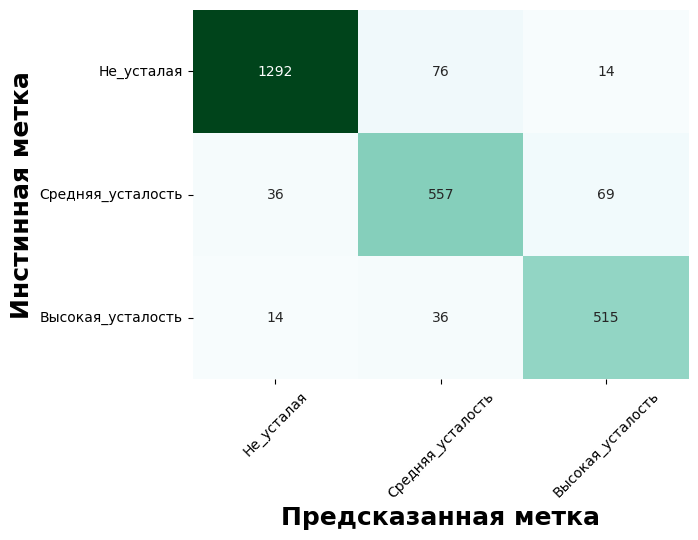

In [78]:
#@title Confusion Matrix
cm = confusion_matrix(y_test, y_test_predict)
df_cm = pd.DataFrame(cm, index=[i for i in activity_labels], columns=[i for i in activity_labels])
plt.figure()
ax= sns.heatmap(df_cm,  cbar=False, cmap="BuGn", annot=True, fmt="d")
plt.setp(ax.get_xticklabels(), rotation=45)

plt.ylabel('Инстинная метка', fontweight='bold', fontsize = 18)
plt.xlabel('Предсказанная метка', fontweight='bold', fontsize = 18)
bottom, top = ax.get_ylim()
plt.show()

In [289]:
# Теперь пропустим все данные для обучения модели 

X_train = FeatureData.drop('class', axis=1)
y_train = FeatureData['class']


classifier = RandomForestClassifier(n_jobs=-1,
                                    random_state = 42,
                                    n_estimators  = 500,
                                    max_depth = 15,
                                    max_leaf_nodes = 200,
                                    max_features = 10,
                                    min_samples_split=8,
                                    min_samples_leaf=2,
                                    min_impurity_decrease = 1e-3,
                                    class_weight={0: 1, 1: 2.12, 2:2.39})

# Train the classifier
classifier.fit(X_train, y_train)

# Сохраняем 
with open('RandomForest.pkl', 'wb') as file:
    pickle.dump(classifier, file)